In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score, KFold

import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
git_df = pd.read_csv('git_stats.csv', index_col=0)
git_df.head()

,full_name,commits,branches,releases,watchers,forks,issues_open,issues_closed,stars
0,mojombo/grit,516,3,15,59,461,9,103,1877
1,wycats/merb-core,1550,14,9,3,54,0,0,407
2,rubinius/rubinius,25379,6,156,116,604,212,2295,2749
3,mojombo/god,813,12,32,106,479,85,53,2074
4,vanpelt/jsawesome,23,1,0,2,2,0,1,37


In [3]:
features = ['commits', 'branches', 'releases', 'watchers', 'forks', 'issues_open', 'issues_closed']
feat_df = git_df[features]
feat_df = (feat_df - feat_df.mean())/feat_df.std()
git_norm_df = git_df.copy()
git_norm_df[features] = feat_df
git_norm_df.head()

,full_name,commits,branches,releases,watchers,forks,issues_open,issues_closed,stars
0,mojombo/grit,0.060243,0.466817,0.493148,1.429572,1.955466,0.630200,0.723755,1877
1,wycats/merb-core,0.302310,4.301474,0.251260,-0.057541,0.162274,-0.132324,-0.055825,407
2,rubinius/rubinius,5.880861,1.512633,6.177532,2.943240,2.585506,17.829343,17.314432,2749
3,mojombo/god,0.129773,3.604264,1.178499,2.677685,2.034772,7.069288,0.345318,2074
4,vanpelt/jsawesome,-0.055172,-0.230393,-0.111573,-0.084096,-0.066831,-0.132324,-0.048256,37


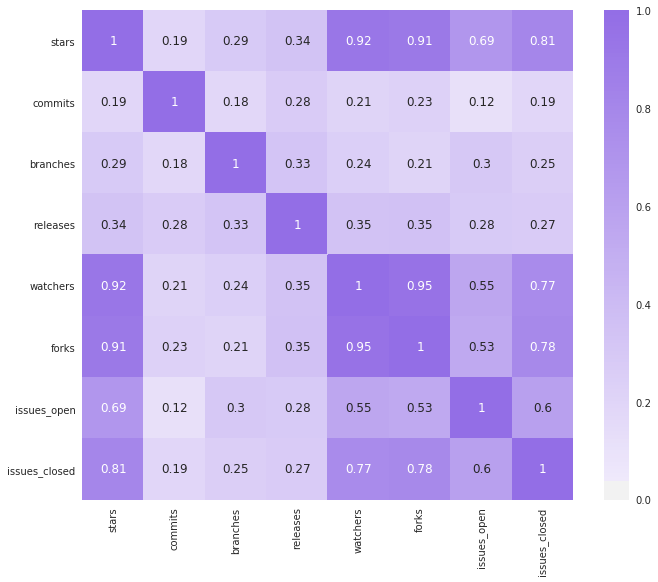

In [4]:
sns.set(style="white")
corr = git_norm_df[['stars'] + features].corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=1, vmin=0, center=0, annot=True)
plt.show()

In [5]:
target = 'stars'

strong_correlated_feats = [
    ['watchers', 'forks'],
    ['watchers'],
    ['forks']
]

correlated_feats = [
    ['watchers', 'forks', 'issues_open'],
    ['watchers', 'issues_open'],
    ['forks', 'issues_open'],
    ['issues_open']
]

uncorrelated_feats = [
    ['commits', 'branches', 'releases'],
    ['commits', 'branches'],
    ['commits', 'releases'],
    ['branches', 'releases'],
    ['commits'],
    ['branches'],
    ['releases']
]

mixed_feats = [
    ['commits', 'branches', 'releases', 'watchers', 'forks', 'issues_open', 'issues_closed'], 
    ['releases', 'watchers', 'forks', 'issues_open'],
    ['branches', 'releases', 'watchers', 'forks'],
    ['branches', 'releases', 'issues_open', 'issues_closed'],
    ['commits','watchers', 'forks'],
    ['commits', 'branches', 'watchers', 'forks']
]

In [6]:
hyper_params = np.arange(1, 21)
folds = np.arange(3, 22, 2)

In [7]:
def eval_setting(df, target, feat_list, hyper_params, folds):
    index = pd.MultiIndex.from_product([np.arange(len(feat_list)),
                                        hyper_params,
                                        folds],
                                       names=['feat_list', 'hyper_param', 'fold'])
    rmse = pd.DataFrame(columns=['avg', 'std'], index=index)

    for i, feats in enumerate(feat_list):
        for hp in hyper_params:
            for fold in folds:
                kf = KFold(fold, shuffle=True, random_state=1)
                model = KNeighborsRegressor(n_neighbors=hp)
                mses = cross_val_score(model,
                                       df[feats],
                                       df[target],
                                       scoring="neg_mean_squared_error",
                                       cv=kf)
                rmses = np.sqrt(np.absolute(mses))
                rmse[i, hp, fold, 'avg'] = np.mean(rmses)
                rmse[i, hp, fold, 'std'] = np.std(rmses)
    return rmse

In [8]:
strong_rmse = eval_setting(git_norm_df, target, strong_correlated_feats, hyper_params, folds)
corr_rmse   = eval_setting(git_norm_df, target, correlated_feats, hyper_params, folds)
uncorr_rmse = eval_setting(git_norm_df, target, uncorrelated_feats, hyper_params, folds)
mixed_rmse  = eval_setting(git_norm_df, target, mixed_feats, hyper_params, folds)

In [9]:
strong_rmse.to_csv('strong_rmse.csv')
corr_rmse.to_csv('corr_rmse.csv')
uncorr_rmse.to_csv('uncorr_rmse.csv')
mixed_rmse.to_csv('mixed_rmse.csv')